# Day 4 Task 3
## Investigating Initial Config Sensitivity

### NIST Initial Configuration

In [1]:
import math

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.

    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced units.

    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
    
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.
    """
    r6_term = math.pow(1/r_ij, 6)
    r12_term = math.pow(r6_term, 2)
    pairwise_energy = 4 * (r12_term - r6_term)
    return pairwise_energy

def calculate_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two 3D coordinates.

    Parameters
    ----------
    coord1, coord2: list
        The atomic coordinates

    Returns
    -------
    distance: float
        The distance between the two points.
    """

    distance = 0
    for i in range(3):
        dim_dist = coord1[i] - coord2[i]

        if box_length:
            dim_dist = dim_dist - box_length * round(dim_dist / box_length)

        dim_dist = dim_dist**2
        distance += dim_dist

    distance = math.sqrt(distance)
    return distance
    
def calculate_total_energy(coordinates, box_length, cutoff):
    """
    Calculate the total Lennard Jones energy of a system of particles.

    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.

    Returns
    -------
    total_energy : float
        The total pairwise Lennard Jones energy of the system of particles.
    """

    total_energy = 0

    num_atoms = len(coordinates)

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):

            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length=box_length)

            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                total_energy += interaction_energy

    return total_energy

def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length

### Random Initial Configuration 

In [2]:
# Generate sample configuration with parameters of number of particles and a desired system density
import random
import math
import matplotlib.pyplot as plt

def rand_sample_config(num_particles, density):
    """
    Parameters
    ----------
    num_particles : integer
        The number of particles to generate 3D coordinates for a random configuration
    density : float
        The density of particles in a box with (num_particles/volume)

    Returns
    -------
    coordinates : list
        A list of randomly generated coordinates [x , y , z] with length == num_particles
    box_length : float
        Calculated length of a box (num_particles/density)**(1/3)
    """

    # Create empty list to store coordinates
    coordinates = []

    #Standardize the random seed to allow reproducibility
    random.seed(0)

    # calculate the box length give number of particles and density
    box_length = math.pow(num_particles/density, (1/3))

    # Generate the points and add to coordinates list
    for i in range(num_particles):
        x_pos = random.uniform(0, box_length)
        y_pos = random.uniform(0, box_length)
        z_pos = random.uniform(0, box_length)
        particle_coordinates = [x_pos, y_pos, z_pos]
        coordinates.append(particle_coordinates)

    return coordinates, box_length

### Cubic Lattice Initial Configuation

In [3]:
import matplotlib.pyplot as plt

def lattice_sample_config(num_particles, density):
    """
    Parameters
    ----------
    num_particles : integer
        The number of particles to generate 3D coordinates for a lattice configuration
    density : float
        The density of particles in a box with (num_particles/volume)

    Returns
    -------
    coordinates : list
        A list of randomly generated coordinates [x , y , z] with length == num_particles
    box_length : float
        Calculated length of a box (num_particles/density)**(1/3)
    """
    
    # Calculate box_length, particles per axis and spacing to build lattice framework
    # Round down to nearest integer for particles per axis to ensure lattice structure
    box_length = math.pow(num_particles/density, (1/3))
    particles_per_axis = math.floor(math.pow(num_particles,(1/3)))
    spacing = box_length/particles_per_axis
    
    # create empty lists to store all coordinates
    coordinates = []

    # create evenly spaced points along all 3 axes
    x_pos = []
    y_pos = []
    z_pos = []
    for i in range(particles_per_axis):
        x_val = (i)*spacing
        x_pos.append(x_val)
    for i in range(particles_per_axis):
        y_val = (i)*spacing
        y_pos.append(y_val)
    for i in range(particles_per_axis):
        z_val = (i)*spacing
        z_pos.append(z_val)
   
    # use the evenly spaced points on the axes to build the lattice structure
    for i in range(len(x_pos)):
        for j in range(len(y_pos)):
            for k in range(len(z_pos)):
                particle_coordinates = [x_pos[i], y_pos[j], z_pos[k]]
                coordinates.append(particle_coordinates)

    return coordinates, box_length

## Energy Calculations

In [4]:
# Perform tail correction for NIST data

def calculate_tail_correction(n_particles, box_length, cutoff):
    '''
    Calculates the tail correction to the internal energy found through the Lennard Jones Equation.
    
    Parameters
    ----------
    n_particles : int
        number of particles created for the simulation
    box_length : float
        length of the sides of the box created for the simulation
    cutoff : float
        cut-off distance
       
    Returns
    -------
    U_lrc : float
        this is the number corresponding with the energy of the particles outside of the defined cut-off limit    
    '''

    volume_of_box = math.pow((box_length),3)
    rc3_term = math.pow((1/cutoff),3)
    rc9_term = math.pow((rc3_term),3)
    inside_term = (((1/3)*rc9_term)-rc3_term)
    U_lrc = (8*math.pi*math.pow((n_particles),2)/(3*volume_of_box))*inside_term
    return U_lrc

In [5]:
def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    '''
    Calculate the interaction energy of a particle with its environment

    Parameters
    ---
    coordinates: list
        the coordinates for all particles in  a system
    i_particle: int
        particle index for which to calulate the energy
    cutoff: float
        the simulation cutoff. beyond this distance the interactions are not calculated.

    Returns
    ---
    e_total: float
        the pairwise interaction energy of the i_th particle with all other particles
    '''

    e_total = 0.0
    i_position = coordinates[i_particle]

    num_atoms = len(coordinates)

    for j_particle in range(num_atoms):
        if i_particle != j_particle:
            
            j_position = coordinates[j_particle]

            r_ij = calculate_distance(i_position, j_position, box_length)

            if r_ij < cutoff:
                e_pair = calculate_LJ(r_ij)
                e_total += e_pair

    return e_total

## Simulation Loop

In [6]:
import random

def accept_or_reject(delta_e, beta):
    '''
    Accept or reject based on an energy and beta (inverse temp) measurement.

    Parameters
    ---
    delta_e: float
        An energy change in reduced units
    beta: float
        Inverse temperature

    return
    ---
    bool
        True to accept move, False to reject
    '''

    if delta_e <= 0.0:
        accept = True
    else:
        random_num = random.random()
        p_acc = math.exp(-delta_e*beta)

        if random_num < p_acc:
            accept = True
        else:
            accept = False

    return accept

In [7]:
#Turned the simulation loop into a function that takes the sample configuration as a parameter

def simulation_loop(sample_config):
    """
    This runs the chosen configuration through the Monte Carlo simulation loop to refine the results.
 
    Parameters
    ----------
    sample_config: tuple
        takes in the `coordinates, box_length` tuple output from the different sample configurations
 
    Returns
    -------
    energies: list
        lists the total energies as calculated through the MC loop
    """
    
    coordinates, box_length = sample_config
    # If we want our results to be reproducible (key for testing)
    random.seed(0)

    # Simulation Parameters
    reduced_temperature = 0.9
    num_steps = 10
    max_displacement = 0.1
    cutoff = 3.0

    freq = 1000

    # Calculated Qtys
    beta = 1/reduced_temperature

    num_particles = len(coordinates)

    delta_energy = 0

    total_energy = calculate_total_energy(coordinates, box_length, cutoff)
    total_energy += calculate_tail_correction(num_particles, box_length, cutoff)
    
    steps = []
    energies = []

    for step in range(num_steps):

        # 1. Randomly pick one of N particles
        random_particle = random.randrange(num_particles)

        # 2. Calculate the interaction energy of the selected particle with the system and store this value.
        current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)

        # 3. Generate a random x, y, z displacement
        x_rand = random.uniform(-max_displacement, max_displacement)
        y_rand = random.uniform(-max_displacement, max_displacement)
        z_rand = random.uniform(-max_displacement, max_displacement)

        # 4. Modify the coordinate of the Nth particle by generated displacements
        coordinates[random_particle][0] += x_rand
        coordinates[random_particle][1] += y_rand
        coordinates[random_particle][2] += z_rand

        # 5. Calculate the interaction energy of the moved particle with the system and store this value.
        proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)

        # 6. Calculate if we accept the move
        delta_e = proposed_energy - current_energy

        accept = accept_or_reject(delta_e, beta)

        # 7. If accept, the move the particle
        if accept:
            total_energy += delta_e
        else:
            # Move is not accept, roll back coordinates
            coordinates[random_particle][0] -= x_rand
            coordinates[random_particle][1] -= y_rand
            coordinates[random_particle][2] -= z_rand    

        # 8. Print the energy if the step is a multiple of the frequency variable
        if step % freq == 0:
            print(step, total_energy/num_particles)
            steps.append(steps)
            energies.append(total_energy)
    return energies

## Running the Different Configurations

In [8]:
# NIST Configuration
config1_file = "../data/sample_config1.txt"

NIST_Config = read_xyz(config1_file)

NIST_Results = simulation_loop(NIST_Config)

0 -5.6886200705459125


In [9]:
# Random Configuration
num_particles = 800
density = 0.8

Random_Config = rand_sample_config(num_particles, density)

Random_Results = simulation_loop(Random_Config)

0 121104985722.95744


In [10]:
# Lattice Configuration
num_particles = 800
density = 0.8

Lattice_Config = lattice_sample_config(num_particles, density)

Lattice_Results = simulation_loop(Lattice_Config)

0 -5.430730756094249


# Reflection

## Approach
I set out by writing down the required elements to answer the question: what effects does changing the initial configuration of the Lennard Jones fluid system have on the sensitivity and accuracy of the Monte Carlo simulation results. Knowing that we have the initial configurations from previous lectures and homework activities, those codes can be altered to achieve a working model. In particular, a `random.seed(0)` line was added for the `random_sample_config` function to ensure that the same seed was used for reproducibility of the results. After altering the baseline configurations to work for the simulation, I turned the simulation loop into to function that takes the `coordinates, box_length` tuple from the sample configurations as a parameter. For running each configuration I ensured that the proper input paramters were included above those lines of code. Finally, I increased the `num_steps` variable in the simulation loop from 10,000 to 100,000 so that the convergence of the total energies could be seen.  

## Observations
Since the simulation runs the energy into a well for the most stable configuration, we can see where they converge by the end results of each test run. 
Comparing the three configurations, it is possible to see that they all converge to a value around **-5**. Even with the starting value of **1.2110*10^11** seen in the random configuration, with time as the simulation seeks out the energy well the final result approaches **-5.5305**.

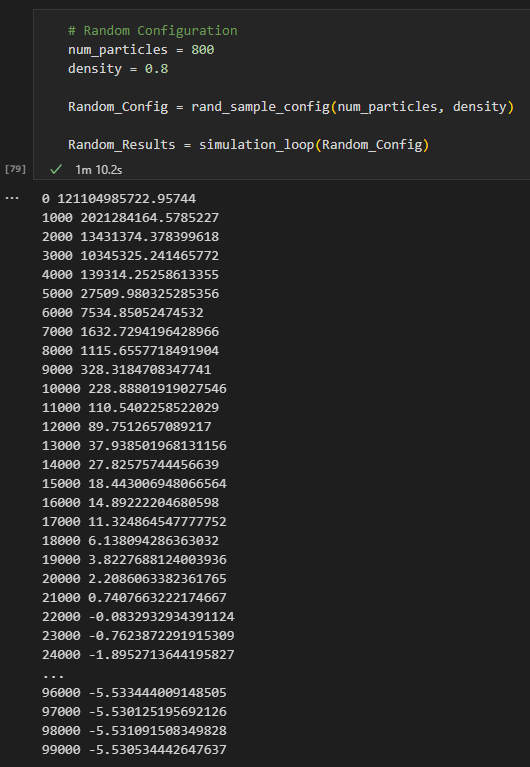

This large starting value and drastic change from start to finish implies that the random configuration starts at a highly unfavorable configuration energetically. 
Interestingly, the lattice and NIST configurations stay pretty similar to their starting values as seen in the figures below.

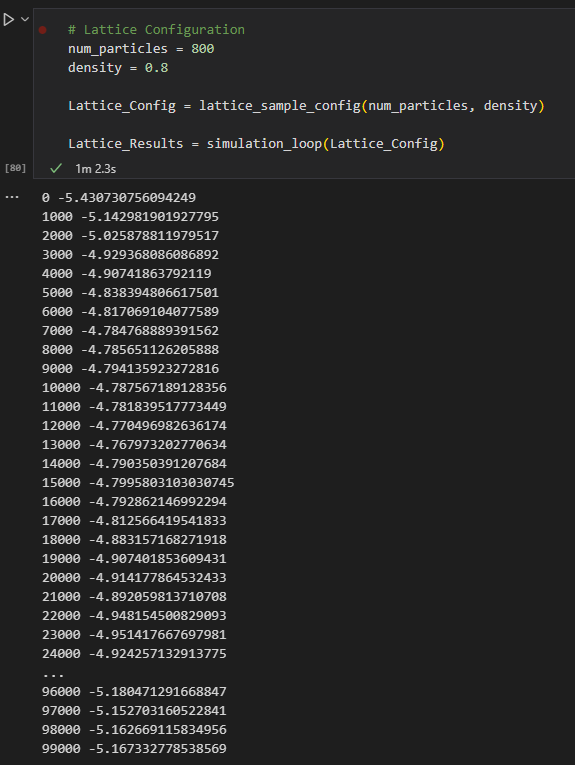
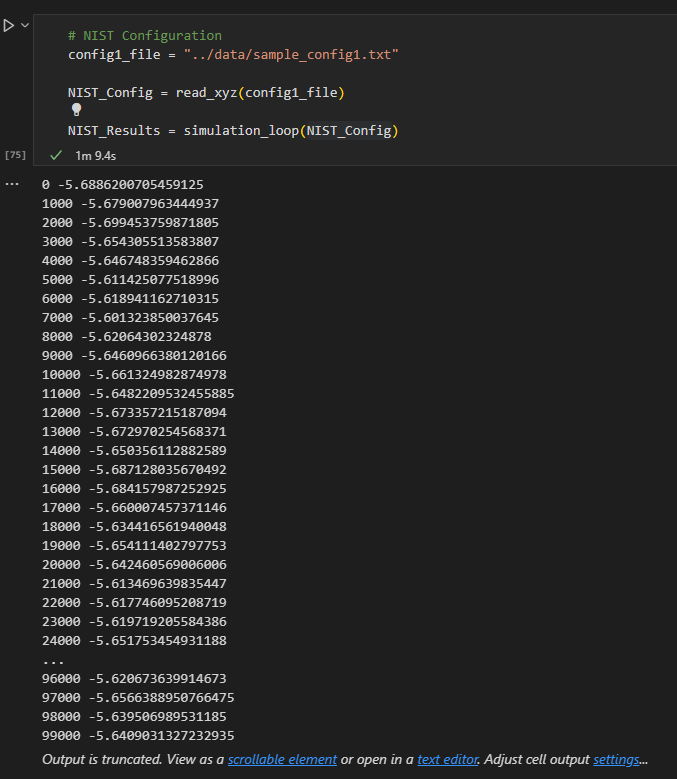

This suggests that these configurations are already near energy wells and any changes made to them does not alter the stability of the system significantly.


